# Compare RMG to the Grabow model

In [2]:
import os
import glob
import itertools
from random import randint
import pandas as pd
import numpy as np
import csv
import cantera as ct
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn
plt.style.use('seaborn-white')
from pathlib import Path
import time

import matplotlib.cm as cm
from IPython.display import Image
import git
from rmgpy import chemkin

## Git-python: checkout master branch

In [3]:
# RMG model path that is being analyzed. cantera analysis have a folder name 
# based off of the commit message, hash, and date
# rmg_model_path = "/work/westgroup/ChrisB/_01_MeOH_repos/RMG_run_comparisons/bep_parameter_study/rmg_runs/meoh_main/"
rmg_model_path = "/work/westgroup/ChrisB/_01_MeOH_repos/meOH-synthesis/"
repo = git.Repo(rmg_model_path)
date = time.localtime(repo.head.commit.committed_date)
git_date = time.strftime("%Y_%m_%d_%H%M", date)
git_sha = str(repo.head.commit)[0:6]
git_msg = str(repo.head.commit.message)[0:50].replace(" ", "_").replace("'", "_").replace("\n", "")
git_file_string = f"{git_date}_{git_sha}_{git_msg}"
commit = git_file_string
commit

'2021_09_22_0110_268b46_ran_with_sandia_reaction_added_in_Surface/Methane/'

## Load a list of reactions for each species generation rate

In [4]:
cti_file = rmg_model_path + "base/cantera/chem_annotated.cti"

gas = ct.Solution(cti_file)
surface = ct.Interface(cti_file, "surface1", [gas])

model_dict_file = rmg_model_path + "base/chemkin/species_dictionary.txt"
grabow_dict_file = "./species_data/species_dictionary.txt"

In [5]:
model_dict = chemkin.load_species_dictionary(model_dict_file)
grabow_dict = chemkin.load_species_dictionary(grabow_dict_file)

In [6]:
# make a dictionary to "translate" the names from the grabow model to ours
# irrespective of the naming convention.
spc_trans = {}
for name, entry in model_dict.items(): 
    for g_name, g_entry in grabow_dict.items():
        if entry.is_isomorphic(g_entry):
            # remove (#) so it is neater
            g_name_new = g_name.split("(", 1)[0]
            spc_trans.update({g_name_new :name})
spc_trans                   

{'N2': 'N2',
 'Ne': 'Ne',
 'X': 'X(1)',
 'H2': 'H2(2)',
 'CO': 'CO(3)',
 'CO2': 'CO2(4)',
 'H2O': 'H2O(5)',
 'CH2O': 'CH2O(6)',
 'HCOOH': 'HCOOH(7)',
 'CH3OH': 'CH3OH(8)',
 'HCOOCH3': 'HCOOCH3(9)',
 'H*': 'H*(10)',
 'O*': 'O*(11)',
 'OH*': 'OH*(12)',
 'H2O*': 'H2O*(13)',
 'CO*': 'CO*(14)',
 'CO2*': 'CO2*(15)',
 'HCO*': 'HCO*(16)',
 'HCOO*': 'HCOO*(17)',
 'COOH*': 'COOH*(18)',
 'HCOOH*': 'HCOOH*(19)',
 'CH2O*': 'CH2O*(20)',
 'CH3O*': 'CH3O*(21)',
 'CH3O2*': 'CH3O2*(22)',
 'CH3OH*': 'CH3OH*(23)',
 'CH4': 'CH4(24)',
 'H2*': 'H2*(37)'}

In [7]:
# read last line from each CSV file
data_dict = {}

# exclude CSP, steady state, and non - sensitivity data
exclude = ["/csp/", "/transient/", "Graaf_experiment_comparison", "analysis_scripts", "kinetics_sensitivity"]

# ensure we don't grab any files that have just printed the 
#column names
min_file_size = 5000

first_file = True
for path in Path(f'./{commit}').rglob('*.csv'):
    path_str = str(path)
    if all(f not in path_str for f in exclude):
        if os.stat(path_str).st_size >= min_file_size:
            if first_file == True: 
                data = pd.read_csv(path_str)
                aggdata = data.tail(1)
                first_file = False
            else: 
                data = pd.read_csv(path_str)
                aggdata = aggdata.append(data.tail(1))

                
print(f"{len(aggdata)} successful runs in commit:\n{commit}")
data_dict.update({commit:aggdata})

176 successful runs in commit:
2021_09_22_0110_268b46_ran_with_sandia_reaction_added_in_Surface/Methane/


## get reactions for each one listed in TOF chart in grabow paper

     Grabow study name      |  Cantera label or formula
     --------------------------------------------------
     "Methanol Production"  |  methanol net production rate  
     "Water-Gas Shift"      |  OH* + CO* -> COOH* + *. although RLS is supp H2O* + X --> H* + *OH
     "CO Hydrogenation"     |  Any reaction where CO receives an H and goes to HCO*. 
     "CO2 Hydrogenation"    |  Any reaction where CO2 receives an H and goes to HCO2*
     "H2O Production"       |  rate of H2O*
     
     
     H2O shift

In [8]:
co_co2_label = "CO2/(CO2+CO)"

In [9]:
for index,rxn in enumerate(surface.reactions()):
    if spc_trans["H2O"] in rxn.equation:
        surface.set_multiplier(0,index)


functions for grabbing ROP data

### methanol

In [10]:
rop_str = " ROP [kmol/m^2 s]"        
ch3oh_dict = {}  
        
for rxn in surface.reactions():
    if spc_trans["CH3OH"] in rxn.equation: 
        rxn_string = rxn.equation + rop_str
        if spc_trans["CH3OH"] in rxn.product_string:
            print(rxn_string, "forward")
            ch3oh_dict.update({rxn_string:1})
        elif spc_trans["CH3OH"] in rxn.reactant_string: 
            print(rxn_string, "reverse")
            ch3oh_dict.update({rxn_string:-1})

CH3OH(8) + X(1) <=> CH3OH*(23) ROP [kmol/m^2 s] reverse
CH3OH(8) + 2 X(1) <=> CH3O*(21) + H*(10) ROP [kmol/m^2 s] reverse


In [11]:
aggdata["Methanol TOF ($s^{-1}$)"] = 0 #(initialize)
for rxn, direct in ch3oh_dict.items():
    if direct == 1:
        aggdata["Methanol TOF ($s^{-1}$)"] += aggdata[rxn]/surface.site_density
    elif direct == -1:
        aggdata["Methanol TOF ($s^{-1}$)"] -= aggdata[rxn]/surface.site_density

### Water-Gas Shift
overall: $CO + H_2O <--> CO_2 + H_2$ 



In [12]:
wgs_hyd_dict = {}
# for rxn in surface.reactions():
# #     if spc_trans["CO*"] in rxn.reactant_string and spc_trans["OH*"] in rxn.reactant_string:
#     if spc_trans["CO2*"] in rxn.reactant_string and spc_trans["COOH*"] in rxn.product_string:
#         rxn_string = rxn.equation + rop_str
#         print(rxn.equation, "forward")
#         wgs_hyd_dict.update({rxn_string:-1})
#     elif spc_trans["COOH*"] in rxn.reactant_string and spc_trans["CO2*"] in rxn.product_string:
#         rxn_string = rxn.equation + rop_str
#         print(rxn.equation, "forward")
#         wgs_hyd_dict.update({rxn_string:1})

In [13]:
# # hardcode HOX(19) + OCX(17) <=> HOCXO(23) + X(1) for now just to analyze
wgs_hyd_dict.update(
    {f'{spc_trans["CO*"]} + {spc_trans["OH*"]} <=> {spc_trans["COOH*"]} + {spc_trans["X"]}{rop_str}':1
#     {f'{spc_trans["H2O*"]} + {spc_trans["X"]} <=> {spc_trans["H*"]} + {spc_trans["OH*"]}{rop_str}':1 
#     {f'{spc_trans["CO*"]} + {spc_trans["OH*"]} <=> {spc_trans["COOH*"]} + {spc_trans["X"]}{rop_str}':1
    }
)

In [14]:
aggdata["WGS Reaction TOF ($s^{-1}$)"] = 0 #(initialize)
for rxn, direct in wgs_hyd_dict.items():
    if direct == 1:
        aggdata["WGS Reaction TOF ($s^{-1}$)"] += aggdata[rxn]/surface.site_density
    elif direct == -1:
        aggdata["WGS Reaction TOF ($s^{-1}$)"] -= aggdata[rxn]/surface.site_density

 ### CO hydrogenation

In [15]:
co_hyd_dict = {}
rop_str = " ROP [kmol/m^2 s]"
for rxn in surface.reactions():
    if spc_trans["CO*"] in rxn.equation and spc_trans["HCO*"] in rxn.equation: 
        rxn_string = rxn.equation + rop_str
        if spc_trans["CO*"] in rxn.reactant_string and not spc_trans["HCO*"] in rxn.reactant_string:
            print(rxn.equation, "forward")
            co_hyd_dict.update({rxn_string:1})
        elif spc_trans["CO*"] in rxn.product_string and not spc_trans["HCO*"] in rxn.product_string: 
            print(rxn.equation, "reverse")
            co_hyd_dict.update({rxn_string:-1})

CO*(14) + H*(10) <=> HCO*(16) + X(1) forward
HCO*(16) + O*(11) <=> CO*(14) + OH*(12) reverse
HCO*(16) + OH*(12) <=> CO*(14) + H2O*(13) reverse
CO2*(15) + HCO*(16) <=> CO*(14) + HCOO*(17) reverse
CO2*(15) + HCO*(16) <=> CO*(14) + COOH*(18) reverse
HCO*(16) + HCOO*(17) <=> CO*(14) + HCOOH*(19) reverse
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) forward
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) forward
CH2O*(20) + CO*(14) <=> 2 HCO*(16) forward
CH2O*(20) + HCO*(16) <=> CH3O*(21) + CO*(14) reverse
HCO*(16) + HCOOH*(19) <=> CH3O2*(22) + CO*(14) reverse
CH3O*(21) + HCO*(16) <=> CH3OH*(23) + CO*(14) reverse
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) forward
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) forward
CO*(14) + H2*(37) <=> H*(10) + HCO*(16) forward


In [16]:
aggdata["CO Hydrogenation TOF ($s^{-1}$)"] = 0 #(initialize)
for rxn, direct in co_hyd_dict.items():
    if direct == 1:
        aggdata["CO Hydrogenation TOF ($s^{-1}$)"] += aggdata[rxn]/surface.site_density
    elif direct == -1:
        aggdata["CO Hydrogenation TOF ($s^{-1}$)"] -= aggdata[rxn]/surface.site_density

### CO2 hydrogenation

In [17]:
co2_hyd_dict = {}
rop_str = " ROP [kmol/m^2 s]"
for rxn in surface.reactions():
    if spc_trans["CO2*"] in rxn.equation and spc_trans["HCOO*"] in rxn.equation: 
        rxn_string = rxn.equation + rop_str
        if spc_trans["CO2*"] in rxn.reactant_string and not spc_trans["HCOO*"] in rxn.reactant_string:
            print(rxn.equation, "forward")
            co2_hyd_dict.update({rxn_string:1})
        elif spc_trans["CO2*"] in rxn.product_string and not spc_trans["HCOO*"] in rxn.product_string: 
            print(rxn.equation, "reverse")
            co2_hyd_dict.update({rxn_string:-1})

CO2*(15) + H*(10) <=> HCOO*(17) + X(1) forward
CO2*(15) + OH*(12) <=> HCOO*(17) + O*(11) forward
HCOO*(17) + OH*(12) <=> CO2*(15) + H2O*(13) reverse
CO2*(15) + HCO*(16) <=> CO*(14) + HCOO*(17) forward
2 HCOO*(17) <=> CO2*(15) + HCOOH*(19) reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) reverse
HCO*(16) + HCOO*(17) <=> CH2O*(20) + CO2*(15) reverse
CH3O*(21) + HCOO*(17) <=> CH3OH*(23) + CO2*(15) reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) reverse
CO2*(15) + H2*(37) <=> H*(10) + HCOO*(17) forward


In [18]:
aggdata["CO2 Hydrogenation TOF ($s^{-1}$)"] = 0 #(initialize)
for rxn, direct in co2_hyd_dict.items():
    if direct == 1:
        aggdata["CO2 Hydrogenation TOF ($s^{-1}$)"] += aggdata[rxn]/surface.site_density
    elif direct == -1:
        aggdata["CO2 Hydrogenation TOF ($s^{-1}$)"] -= aggdata[rxn]/surface.site_density

### H2O production

In [19]:
h2o_dict = {}        
for rxn in surface.reactions():
    if spc_trans["H2O"] in rxn.equation: 
        rxn_string = rxn.equation + rop_str
        if spc_trans["H2O"] in rxn.reactant_string:
            print(rxn.equation, "reverse")
            h2o_dict.update({rxn_string:-1})
        elif spc_trans["H2O"] in rxn.product_string: 
            print(rxn.equation, "forward")
            h2o_dict.update({rxn_string:1}) 

H2O(5) + X(1) <=> H2O*(13) reverse
H2O(5) + 2 X(1) <=> H*(10) + OH*(12) reverse


In [20]:
aggdata["H2O TOF ($s^{-1}$)"] = 0 #(initialize)
for rxn, direct in h2o_dict.items():
    if direct == 1:
        aggdata["H2O TOF ($s^{-1}$)"] += aggdata[rxn]/surface.site_density
    elif direct == -1:
        aggdata["H2O TOF ($s^{-1}$)"] -= aggdata[rxn]/surface.site_density

### surface site density ($\frac{kmol}{m^2}$)

In [21]:
surface.site_density
site_dens_mol = surface.site_density*1e-3
site_dens_mol

2.943e-11

### TOF Calculation from ROP: 

$ROP\left[\frac{kmoles}{m^{2}*s}\right] * \frac{1}{\Gamma} \left[\frac{m^2}{kmol}\right] = TOF \left[\frac{1}{sec}\right]$   

## Turn over frequency comparison

Compare turn over frequencies for reaction(s) in the methanol model



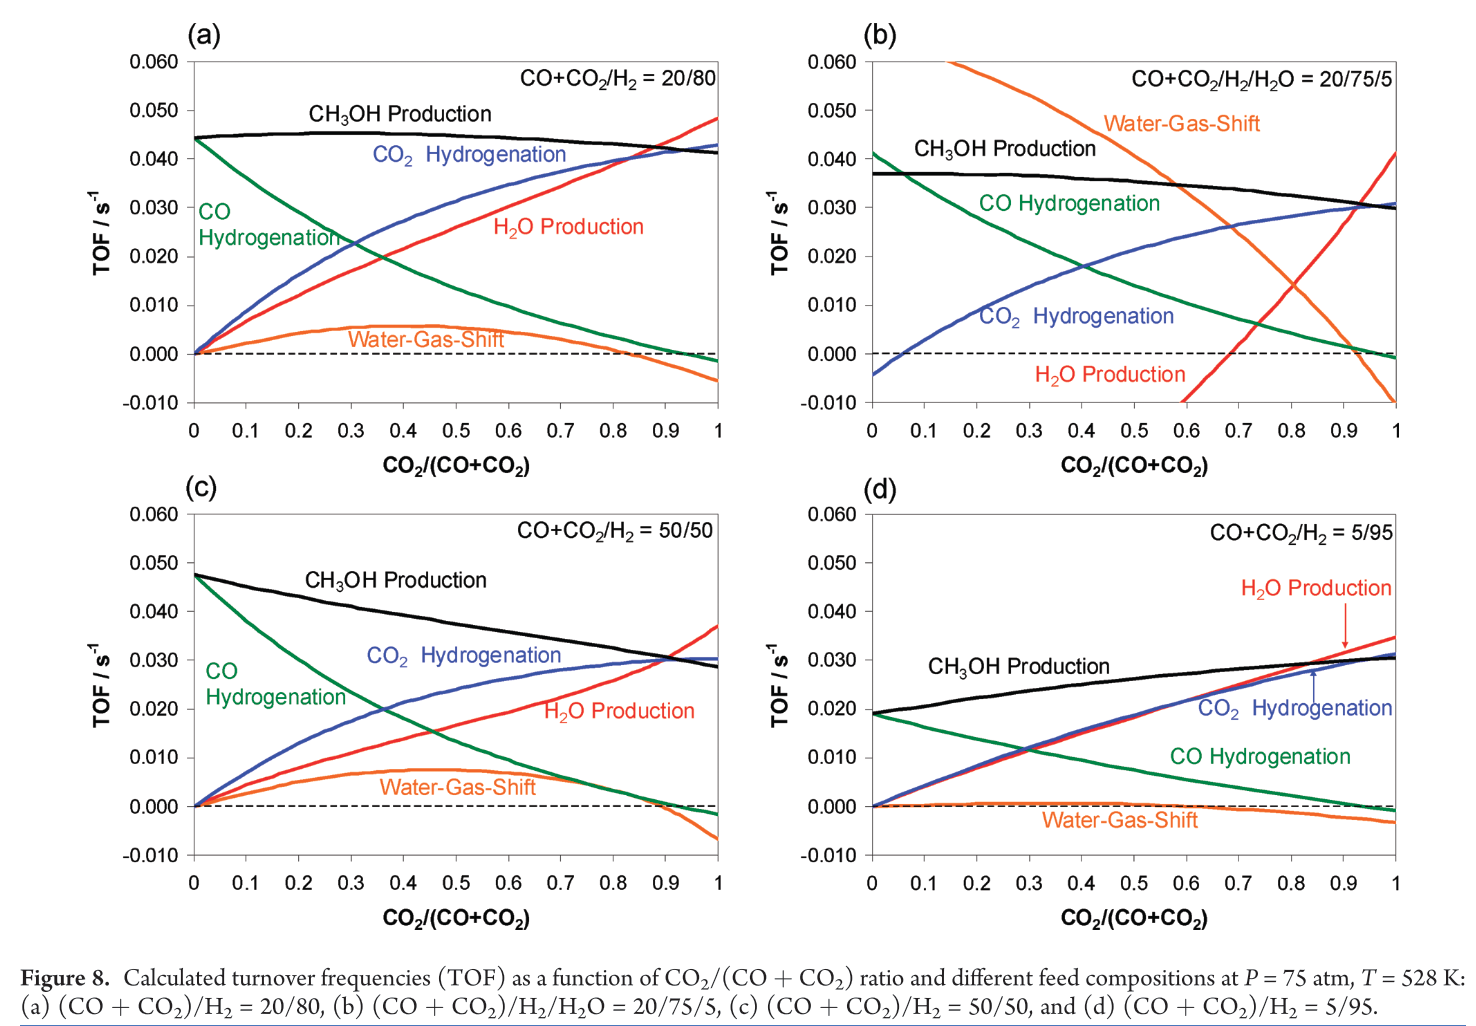

In [22]:
Image('../images/Grabow_plots/Grabow_TOF.png',width = 700, height = 300)

### Load Grabow Data

In [23]:
Grabow_rates = pd.read_csv("../Grabow_data/Paper_plot_data/Grabow_rates.csv")
Grabow_cov = pd.read_csv("../Grabow_data/Paper_plot_data/Grabow_coverages.csv")

### Make TOF plot functions

In [24]:
def plot_rates_grabow(df):
    '''
    This function returns a 2x2 set of charts like the ones above, 
    for comparison with the grabow rates and coverages. 
    df - dataframe to load
    labels - list of labels to use. first is the "x" values, then the y
    '''
    h2_mol = [0.5, 0.75, 0.8, 0.95]
    grabow_labels = [
        "Methanol Production",
        "Water-Gas Shift",
        "CO Hydrogenation",
        "CO2 Hydrogenation",
        "H2O Production",]
    
    h2_label = "y(H2)"
    co_co2_label = "CO2/(CO+CO2)"
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    
    axes = [(0,0), (0,1), (1,0), (1,1)]
    
    color_dict = { 0:"k", 1:"y", 2:"g", 3:"b", 4:"r"}

    for coord,h2 in enumerate(h2_mol):
        
        for color,label in enumerate(grabow_labels):
            # "slot" where we place chart
            slot = axes[coord]
            df[np.isclose(df["y(H2)"], h2)].plot(x=co_co2_label,
                                                 y=label,
                                                 ax=ax[slot], 
                                                 color=color_dict[color],
                                                )
            ax[slot].set_title(f'mole frac H2 = {h2}')
            ax[slot].autoscale(enable=True, axis='y')
            ax[slot].set_ylabel("Turn over frequency ($s^{-1}$)")

def plot_rates_rmg(df):
    '''
    This function returns a 2x2 set of charts like the ones above, 
    for comparison with the grabow rates and coverages. 
    df - dataframe to load
    labels - list of labels to use. first is the "x" values, then the y
    '''
    
    h2_mol = [0.5, 0.75, 0.8, 0.95]
    # this part is tricky. 
    
    #         "Methanol Production"  :  CH3O* + H* -> CH3OH* + *;
    #         "Water-Gas Shift"      :  OH* + CO* -> COOH* + *
    #         "CO Hydrogenation"     :  CO* + H* -> HCO* + *
    #         "CO2 Hydrogenation"    :  CO2* + H* -> HCO2* + *
    #         "H2O Production"       :  #1 - #2
                                        #1:  H2O*+*->OH*+H*
    #                                   #2:  COOH* + OH* -> CO2* + H2O*
    rmg_labels = [
        "Methanol TOF ($s^{-1}$)",
        "WGS Reaction TOF ($s^{-1}$)",
        "CO Hydrogenation TOF ($s^{-1}$)",
        "CO2 Hydrogenation TOF ($s^{-1}$)",
        "H2O TOF ($s^{-1}$)",
    ]
        
    h2_label = "X_h2 initial"
    co_co2_label = "CO2/(CO2+CO)"
    color_dict = { 0:"k", 1:"y", 2:"g", 3:"b", 4:"r"}
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    axes = [(0,0), (0,1), (1,0), (1,1)]

    for coord,h2 in enumerate(h2_mol):
        
        for color,label in enumerate(rmg_labels):
            # "slot" where we place chart
            slot = axes[coord]
            df[np.isclose(df[h2_label], h2)].plot(x=co_co2_label,
                                                 y=label,
                                                 ax =ax[slot], 
                                                 color=color_dict[color],
                                                )
            ax[slot].set_title(f'mole frac H2 = {h2}')
            ax[slot].autoscale(enable=True, axis='y')
            ax[slot].set_ylabel("Turn over frequency ($s^{-1}$)")



### Plot TOFs

In [25]:
plot_rates_grabow(Grabow_rates)

In [26]:
plot_rates_rmg(aggdata[aggdata["T (K)"] == 528])

## Coverage comparison

Look at the surface coverage and gas phase concentrations for key species

## Plot coverage functions

In [27]:
def plot_covs_grabow(df):
    '''
    This function returns a 2x2 set of charts like the ones above, 
    for comparison with the rmg rates and coverages. 
    df - dataframe to load
    '''
    
    h2_mol = [0.5, 0.75, 0.8, 0.95]
    grabow_labels = [
        "vacant",
        "HCOO",
        "CH3O",
        "H",
        "OH",
    ]
    
    h2_label = "y(H2)"
    co_co2_label = "CO2/(CO+CO2)"
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    
    axes = [(0,0), (0,1), (1,0), (1,1)]
    
    color_dict = { 0:"k", 1:"y", 2:"g", 3:"b", 4:"r"}

    for coord,h2 in enumerate(h2_mol):
        
        for color,label in enumerate(grabow_labels):
            # "slot" where we place chart
            slot = axes[coord]
            df[np.isclose(df["y(H2)"], h2)].plot(x=co_co2_label,
                                                 y=label,
                                                 ax=ax[slot], 
                                                 color=color_dict[color],
                                                )
            ax[slot].set_title(f'mole frac H2 = {h2}')
            ax[slot].autoscale(enable=True, axis='y')
            ax[slot].set_ylabel("site fraction")

def plot_covs_rmg(df, labels, gas=False):
    '''
    This function returns a 2x2 set of charts like the ones above, 
    for comparison with the grabow rates and coverages. 
    df - dataframe to load
    labels - list of labels to use. first is the "x" values, then the y
    '''
    
    h2_mol = [0.5, 0.75, 0.8, 0.95]
    
    rmg_labels = labels
        
    h2_label = "X_h2 initial"
    co_co2_label = "CO2/(CO2+CO)"
    color_dict = { 0:"k", 1:"y", 2:"g", 3:"b", 4:"r", 5:"deeppink"}
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    axes = [(0,0), (0,1), (1,0), (1,1)]

    for coord,h2 in enumerate(h2_mol):
        
        for color,label in enumerate(rmg_labels):
            # "slot" where we place chart
            slot = axes[coord]
            df[np.isclose(df[h2_label], h2)].plot(x=co_co2_label,
                                                 y=label,
                                                 ax =ax[slot], 
                                                 color=color_dict[color],
                                                )
            ax[slot].set_title(f'mole frac H2 = {h2}')
            ax[slot].autoscale(enable=True, axis='y')
            if gas: 
                ax[slot].set_ylabel("mole fraction")
            else: 
                ax[slot].set_ylabel("site fraction")

In [28]:
plot_covs_grabow(Grabow_cov)

In [29]:
labels = [
    spc_trans["CO"],
    spc_trans["CO2"],
    spc_trans["H2O"],
    spc_trans["CH3OH"],
    spc_trans["H2"],
]

plot_covs_rmg(aggdata[aggdata["T (K)"] == 528], labels, gas=True)

In [30]:
labels = [
    spc_trans["X"],
    spc_trans["HCOO*"],
    spc_trans["CH3O*"],
    spc_trans["H*"],
    spc_trans["OH*"],
    spc_trans["H2O*"]
]

plot_covs_rmg(aggdata[aggdata["T (K)"] == 528], labels)

In [31]:
# get the maximum values
max_dist = 2
imp_species = []

h2 = 0.5
co_co2 = 0.5


df_short = aggdata[(aggdata["T (K)"] == 528) & \
                   np.isclose(aggdata["X_h2 initial"],h2) & \
                   np.isclose(aggdata["CO2/(CO2+CO)"],co_co2)]
thresh = 1e-6

print(f'Species Steady state concentrations that go above :{thresh}', '\n')

for i in range (15, len(df_short.columns)):

    column = df_short[df_short.columns[i]]
    max_value = column.max()
    max_index = column.idxmax()

    if max_value >= thresh and (("X" in df_short.columns[i]) or \
                              ("Pt" in df_short.columns[i]) or \
                              ("Pd" in df_short.columns[i]) or \
                              ("*" in df_short.columns[i])) \
    and not "ROP" in df_short.columns[i] \
    and not "sensitivity" in df_short.columns[i]:

        imp_species.append(df_short.columns[i])
        print(df_short.columns[i], "Max = " "{:.10f}".format(max_value))

Species Steady state concentrations that go above :1e-06 

X(1) Max = 0.4728645888
H*(10) Max = 0.0156910640
H2O*(13) Max = 0.0004962667
CO*(14) Max = 0.4121609590
CO2*(15) Max = 0.0000418219
HCO*(16) Max = 0.0056322102
CH2O*(20) Max = 0.0015961550
CH3OH*(23) Max = 0.0915161464


In [32]:
# get the maximum values
max_dist = 2
imp_rxns = {}

h2 = 0.5
co_co2 = 0.5

df_short = aggdata[(aggdata["T (K)"] == 528) & \
                   np.isclose(aggdata["X_h2 initial"],h2) & \
                   np.isclose(aggdata["CO2/(CO2+CO)"],co_co2)]

df_short
thresh = 1e-15

print(f'Species Steady state ROPs that go above :{thresh}', '\n')

for i in range (15, len(df_short.columns)):

    column = df_short[df_short.columns[i]]
    max_value = column.max()
    max_index = column.idxmax()

    if max_value >= thresh and "ROP" in df_short.columns[i] \
    and "<=>" in df_short.columns[i] \
    and not "sensitivity" in df_short.columns[i]:

        max_value_TOF = max_value/surface.site_density
        tof_label = df_short.columns[i].replace("ROP [kmol/m^2 s]","TOF [1/s]")
        imp_rxns.update({tof_label:max_value_TOF})
#         print(df_short.columns[i], "Max = " "{:.10f}".format(max_value_TOF))
        
imp_rxns = {k: v for k, v in sorted(imp_rxns.items(), key=lambda item: item[1], reverse = True)}

for key, value in imp_rxns.items(): 
    print("{:60s} : {:4e} ".format(key,value))

Species Steady state ROPs that go above :1e-15 

H2(2) + 2 X(1) <=> 2 H*(10) TOF [1/s]                        : 7.125970e-02 
CH2O*(20) + H*(10) <=> CH3O*(21) + X(1) TOF [1/s]            : 7.006952e-02 
H*(10) + HCO*(16) <=> CH2O*(20) + X(1) TOF [1/s]             : 3.475172e-02 
CO(3) + X(1) <=> CO*(14) TOF [1/s]                           : 3.380553e-02 
CO2(4) + X(1) <=> CO2*(15) TOF [1/s]                         : 1.332302e-03 
CO2*(15) + HCO*(16) <=> CO*(14) + COOH*(18) TOF [1/s]        : 1.317062e-03 
HCOOH(7) + X(1) <=> HCOOH*(19) TOF [1/s]                     : 1.316654e-03 
H*(10) + HCOOH*(19) <=> H2O*(13) + HCO*(16) TOF [1/s]        : 1.310322e-03 
CH2O(6) + X(1) <=> CH2O*(20) TOF [1/s]                       : 1.841510e-04 
HCOOH(7) + 2 X(1) <=> HCO*(16) + OH*(12) TOF [1/s]           : 5.698751e-05 
CO2(4) + H*(10) <=> HCOO*(17) TOF [1/s]                      : 2.977517e-05 
CO2*(15) + H*(10) <=> HCOO*(17) + X(1) TOF [1/s]             : 1.514769e-05 
CO2(4) + H*(10) <=> COOH*(1

In [33]:
# get the maximum values
max_dist = 2
imp_rxns = {}
h2 = 0.5
co_co2 = 0.5

df_short = aggdata[(aggdata["T (K)"] == 528) & \
                   np.isclose(aggdata["X_h2 initial"],h2) & \
                   np.isclose(aggdata["CO2/(CO2+CO)"],co_co2)]
df_short
thresh = -1e-15

print(f'Species Steady state ROPs that go below :{thresh}', '\n')

for i in range (15, len(df_short.columns)):

    column = df_short[df_short.columns[i]]
    max_value = column.min()
    max_index = column.idxmin()

    if max_value <= thresh and "ROP" in df_short.columns[i] \
    and "<=>" in df_short.columns[i] \
    and not "sensitivity" in df_short.columns[i]:

        max_value_TOF = max_value/surface.site_density
        tof_label = df_short.columns[i].replace("ROP [kmol/m^2 s]","TOF [1/s]")
        imp_rxns.update({tof_label:max_value_TOF})
#         print(df_short.columns[i], "Max = " "{:.10f}".format(max_value_TOF))
        
imp_rxns = {k: v for k, v in sorted(imp_rxns.items(), key=lambda item: item[1], reverse = False)}

for key, value in imp_rxns.items(): 
    print("{:60s} : {:4e} ".format(key,value))

Species Steady state ROPs that go below :-1e-15 

CH2O*(20) + HCO*(16) <=> CH3O*(21) + CO*(14) TOF [1/s]       : -3.512714e-02 
CH3OH(8) + 2 X(1) <=> CH3O*(21) + H*(10) TOF [1/s]           : -3.470700e-02 
HCOOH(7) + 2 X(1) <=> COOH*(18) + H*(10) TOF [1/s]           : -1.329075e-03 
H2O(5) + X(1) <=> H2O*(13) TOF [1/s]                         : -1.310599e-03 
CH4(24) + CO2(4) <=> HCOOCH3(9) ROP [kmol/m^3 s]             : -2.444876e-04 
HCOOCH3(9) + 2 X(1) <=> CH3O*(21) + HCO*(16) TOF [1/s]       : -2.352938e-04 
CH2O(6) + 2 X(1) <=> H*(10) + HCO*(16) TOF [1/s]             : -1.850000e-04 
H2O(5) + 2 X(1) <=> H*(10) + OH*(12) TOF [1/s]               : -6.377459e-05 
HCOOH(7) + 2 X(1) <=> H*(10) + HCOO*(17) TOF [1/s]           : -4.496710e-05 
CH2O*(20) + OH*(12) <=> CH3O2*(22) + X(1) TOF [1/s]          : -6.434070e-06 
HCO*(16) + OH*(12) <=> COOH*(18) + H*(10) TOF [1/s]          : -2.418376e-07 
CO*(14) + OH*(12) <=> COOH*(18) + X(1) TOF [1/s]             : -1.633638e-07 
CH3OH(8) + X(1

## Plot potential energy surface

plot the enthalpy vs reaction coordinate

In [34]:
import cantera as ct
from IPython.display import Image
%matplotlib inline

import os
import sys
import git
import time
sys.path.append(f'/work/westgroup/ChrisB/_01_MeOH_repos/PES_plotter')
sys.path.append(f'/work/westgroup/ChrisB/_01_MeOH_repos/PES_plotter/PyEnergyDiagram')
import pes_plot
import numpy as np

### Hydrogen adsorption/desorption

Hydrogen dissociation vs van der waals adsorption  
the paths available are almost equivalent. H2X is higher energy. to see why it persists we need to examine the later reactions with H2X vs the ones available to H2 

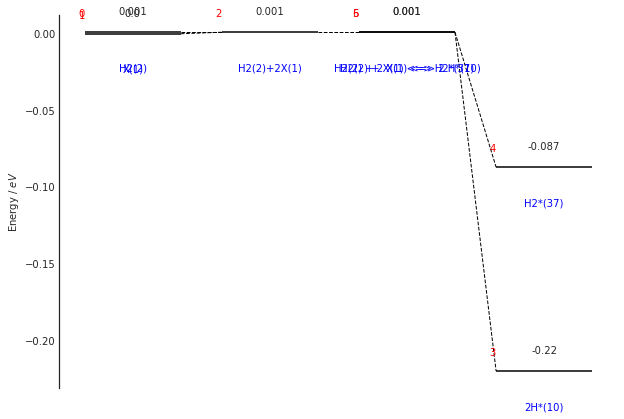

In [35]:
ppt = pes_plot.pes_plot(cti_file)
species1 = [
    spc_trans["H2"],
    spc_trans["X"],
]

h2_gr = [(spc_trans["H2"],1),(spc_trans["X"],2)]
hx_gr = [(spc_trans["H*"],2)]
h2x_gr = [(spc_trans["H2*"])]

ppt.add_species(species1, 0)
ppt.add_combined_specie(h2_gr, 1)
ppt.add_combined_species([hx_gr, h2x_gr], 3)

ppt.add_reaction(f'{spc_trans["H2"]} + 2 {spc_trans["X"]} <=> 2 {spc_trans["H*"]}',2)
ppt.add_reaction(f'{spc_trans["H2"]} + {spc_trans["X"]} <=> {spc_trans["H2*"]}',2)
ppt.plot()


## COOH to HCOOH

In [36]:
reactant = spc_trans["CO2*"]
product = spc_trans["HCO*"]
rxn_list = []
rev_rxn_list = []
reactant_list = []
product_list = []
for rxn in surface.reactions():
    if reactant in rxn.reactants and product in rxn.products:
        rxn_list.append(rxn.equation)
        print(
            rxn.equation, 
            rxn.rate.activation_energy, 
            rxn.rate.pre_exponential_factor,
            rxn.rate.temperature_exponent,
        )
        reactant_list.append([(s,st) for s,st in rxn.reactants.items()])
        product_list.append([(s,st) for s,st in rxn.products.items()])
    if reactant in rxn.products and product in rxn.reactants:
        rev_rxn_list.append(rxn.equation)
        print(
            rxn.equation, 
            rxn.rate.activation_energy, 
            rxn.rate.pre_exponential_factor,
            rxn.rate.temperature_exponent,
            "reverse",
        )
        reactant_list.append([(s,st) for s,st in rxn.products.items()])
        product_list.append([(s,st) for s,st in rxn.reactants.items()])        

HCO*(16) + HCOO*(17) <=> CH2O*(20) + CO2*(15) 117792152.0 3.2e+20 0.0 reverse
COOH*(18) + HCO*(16) <=> CH2O*(20) + CO2*(15) 107926280.0 3.2e+20 0.0 reverse


In [37]:
reactant = spc_trans["CO2*"]
product = spc_trans["HCOO*"]
# rxn_list = []
# rev_rxn_list = []
# reactant_list = []
# product_list = []
for rxn in surface.reactions():
    if reactant in rxn.reactants and product in rxn.products:
        rxn_list.append(rxn.equation)
        print(
            rxn.equation, 
            rxn.rate.activation_energy, 
            rxn.rate.pre_exponential_factor,
            rxn.rate.temperature_exponent,
        )
        reactant_list.append([(s,st) for s,st in rxn.reactants.items()])
        product_list.append([(s,st) for s,st in rxn.products.items()])
    if reactant in rxn.products and product in rxn.reactants:
        rev_rxn_list.append(rxn.equation)
        print(
            rxn.equation, 
            rxn.rate.activation_energy, 
            rxn.rate.pre_exponential_factor,
            rxn.rate.temperature_exponent,
            "reverse",
        )
        reactant_list.append([(s,st) for s,st in rxn.products.items()])
        product_list.append([(s,st) for s,st in rxn.reactants.items()]) 

CO2*(15) + H*(10) <=> HCOO*(17) + X(1) 83943592.0 1.243e+21 0.0
CO2*(15) + OH*(12) <=> HCOO*(17) + O*(11) 40522040.0 3.628e+19 0.0
HCOO*(17) + OH*(12) <=> CO2*(15) + H2O*(13) 49270784.0 3.2e+20 0.0 reverse
CO2*(15) + HCO*(16) <=> CO*(14) + HCOO*(17) 40522040.0 3.628e+19 0.0
2 HCOO*(17) <=> CO2*(15) + HCOOH*(19) 84014720.0 3.2e+20 0.0 reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) 74148848.0 3.2e+20 0.0 reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) 74148848.0 3.2e+20 0.0 reverse
HCO*(16) + HCOO*(17) <=> CH2O*(20) + CO2*(15) 117792152.0 3.2e+20 0.0 reverse
CH3O*(21) + HCOO*(17) <=> CH3OH*(23) + CO2*(15) 63065432.0 3.2e+20 0.0 reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) 74148848.0 3.2e+20 0.0 reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) 74148848.0 3.2e+20 0.0 reverse
CO2*(15) + H2*(37) <=> H*(10) + HCOO*(17) 94449616.0 13522550000000.0 1.181


In [38]:
reactant = spc_trans["CO2"]
product = spc_trans["CO2*"]
rxn_list = []
rev_rxn_list = []
reactant_list = []
product_list = []
for rxn in surface.reactions():
    if reactant in rxn.reactants and product in rxn.products:
        rxn_list.append(rxn.equation)
        print(
            rxn.equation, 
            rxn.rate.activation_energy, 
            rxn.rate.pre_exponential_factor,
            rxn.rate.temperature_exponent,
        )
        reactant_list.append([(s,st) for s,st in rxn.reactants.items()])
        product_list.append([(s,st) for s,st in rxn.products.items()])
    if reactant in rxn.products and product in rxn.reactants:
        rev_rxn_list.append(rxn.equation)
        print(
            rxn.equation, 
            rxn.rate.activation_energy, 
            rxn.rate.pre_exponential_factor,
            rxn.rate.temperature_exponent,
            "reverse",
        )
        reactant_list.append([(s,st) for s,st in rxn.products.items()])
        product_list.append([(s,st) for s,st in rxn.reactants.items()]) 

CO2(4) + X(1) <=> CO2*(15) 0.0 0.005 0.0


In [39]:
rxn_list

['CO2(4) + X(1) <=> CO2*(15)']

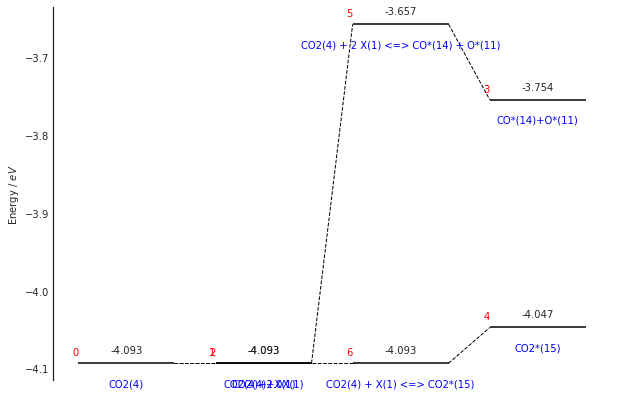

In [40]:
ppt = pes_plot.pes_plot(cti_file)

reactant_list = [
    [(spc_trans['CO2'], 1.0), (spc_trans['X'], 2.0)],
    [(spc_trans['CO2'], 1.0), (spc_trans['X'], 1.0)]
]
product_list = [
    [(spc_trans['CO*'], 1.0), (spc_trans['O*'], 1.0)],
    [(spc_trans['CO2*'], 1.0)],
]
rxn_list = ['CO2(4) + 2 X(1) <=> CO*(14) + O*(11)',
           'CO2(4) + X(1) <=> CO2*(15)'
           ]

ppt.add_specie(spc_trans["CO2"], 0)
ppt.add_reactions(rxn_list, 2)
# ppt.add_reactions(rev_rxn_list,2,True)
ppt.add_combined_species(reactant_list,1)
ppt.add_combined_species(product_list, 3)

ppt.plot()

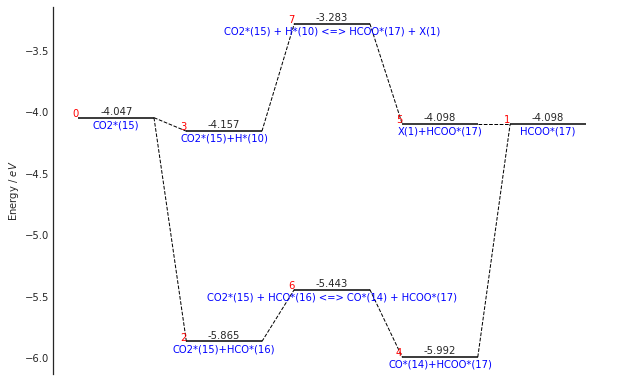

In [41]:
ppt = pes_plot.pes_plot(cti_file)

reactant_list = [
    [('CO2*(15)', 1.0), ('HCO*(16)', 1.0)],
    [('CO2*(15)', 1.0), ('H*(10)', 1.0)]
]
product_list = [
    [('CO*(14)', 1.0), ('HCOO*(17)', 1.0)],
    [('X(1)', 1.0), ('HCOO*(17)', 1.0)],
]
rxn_list = [
    'CO2*(15) + HCO*(16) <=> CO*(14) + HCOO*(17)',
    'CO2*(15) + H*(10) <=> HCOO*(17) + X(1)',
]

ppt.add_specie(spc_trans["CO2*"], 0)
ppt.add_reactions(rxn_list, 2)
# ppt.add_reactions(rev_rxn_list,2,True)
ppt.add_combined_species(reactant_list,1)
ppt.add_combined_species(product_list, 3)
ppt.add_specie(spc_trans["HCOO*"],4)

ppt.plot()

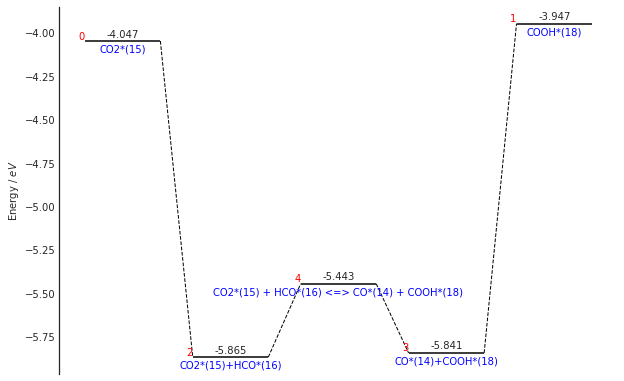

In [42]:
ppt = pes_plot.pes_plot(cti_file)

reactant_list = [
    [('CO2*(15)', 1.0), ('HCO*(16)', 1.0)]
]
product_list = [
    [('CO*(14)', 1.0), ('COOH*(18)', 1.0)]
]
rxn_list = ['CO2*(15) + HCO*(16) <=> CO*(14) + COOH*(18)',]
ppt.add_specie(spc_trans["CO2*"], 0)
ppt.add_reactions(rxn_list, 2)
# ppt.add_reactions(rev_rxn_list,2,True)
ppt.add_combined_species(reactant_list,1)
ppt.add_combined_species(product_list, 3)
ppt.add_specie(spc_trans["COOH*"],4)

ppt.plot()

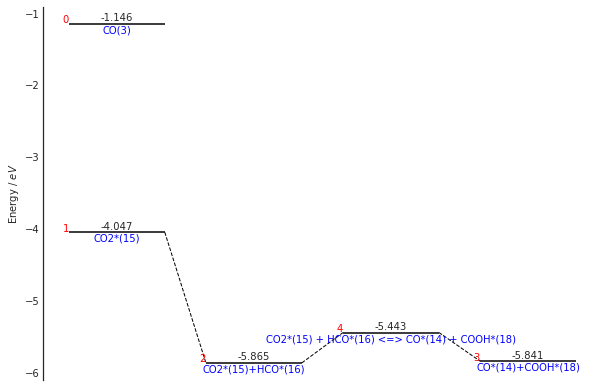

In [43]:
ppt = pes_plot.pes_plot(cti_file)
species = [
#     'H*(10)',
    spc_trans["CO"],
    spc_trans["CO2*"],
]
ppt.add_species(species, 0)
ppt.add_combined_species(reactant_list,1)
ppt.add_reactions(rxn_list, 2)
ppt.add_combined_species(product_list, 3)
# ppt.add_specie(spc_trans["HCOOH*"],0)
# ppt.add_specie(spc_trans["HCOOH"],0)
ppt.plot()

## $CO_2/CO$ adsorption and subsequent reactions

get a list of reactions for CO to COOH*(18)

In [44]:
# get reactants for CO2 to go to carbonyl
reactant = spc_trans["CO*"]
product = spc_trans["COOH*"]
rxn_list = []
reactant_list = []
product_list = []
for rxn in surface.reactions():
    if reactant in rxn.reactants and product in rxn.products:
        rxn_list.append(rxn.equation)
        print(
            rxn.equation, 
            rxn.rate.activation_energy, 
            rxn.rate.pre_exponential_factor,
            rxn.rate.temperature_exponent,
        )
        reactant_list.append([(s,st) for s,st in rxn.reactants.items()])
        product_list.append([(s,st) for s,st in rxn.products.items()])

CO*(14) + OH*(12) <=> COOH*(18) + X(1) 11501816.0 4.02e+17 0.0
CO*(14) + H2O*(13) <=> COOH*(18) + H*(10) 121704192.0 2.073936e+16 0.937
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) 121704192.0 1.036968e+16 0.937
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) 121704192.0 1.036968e+16 0.937
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) 121704192.0 1.036968e+16 0.937
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) 121704192.0 1.036968e+16 0.937


species CO*(14)+HCOOH*(19) already in this diagram position
species CO*(14)+HCOOH*(19) already in this diagram position
species CO*(14)+HCOOH*(19) already in this diagram position
reaction CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) already in this diagram position
reaction CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) already in this diagram position
reaction CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) already in this diagram position
species COOH*(18)+HCO*(16) already in this diagram position
species COOH*(18)+HCO*(16) already in this diagram position
species COOH*(18)+HCO*(16) already in this diagram position


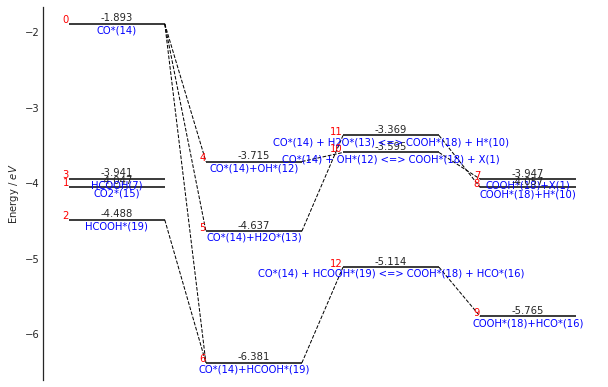

In [45]:
ppt = pes_plot.pes_plot(cti_file)
species = [
#     'H*(10)',
    spc_trans["CO*"],
    spc_trans["CO2*"],
]
ppt.add_species(species, 0)
ppt.add_combined_species(reactant_list,1)
ppt.add_reactions(rxn_list, 2)
ppt.add_combined_species(product_list, 3)
ppt.add_specie(spc_trans["HCOOH*"],0)
ppt.add_specie(spc_trans["HCOOH"],0)
ppt.plot()

In [46]:
reactant = spc_trans["CO*"]
product = spc_trans["HCO*"]
rxn_list = []
reactant_list = []
product_list = []
for rxn in surface.reactions():
    if reactant in rxn.reactants and product in rxn.products:
        rxn_list.append(rxn.equation)
        reactant_list.append([(s,int(st)) for s,st in rxn.reactants.items()])
        product_list.append([(s,int(st)) for s,st in rxn.products.items()])

In [47]:
if "HCOOH*" in spc_trans.keys():
    reactant = spc_trans["HCOOH*"]
    product = spc_trans["COOH*"]
    rxn_list = []
    reactant_list = []
    product_list = []
    for rxn in surface.reactions():
        if reactant in rxn.reactants and product in rxn.products:
            rxn_list.append(rxn.equation)
            print(
                rxn.equation, 
                rxn.rate.activation_energy, 
                rxn.rate.pre_exponential_factor,
                rxn.rate.temperature_exponent,
            )
            reactant_list.append([(s,int(st)) for s,st in rxn.reactants.items()])
            product_list.append([(s,int(st)) for s,st in rxn.products.items()])
else: 
    print("sorry, no formic acid")

HCOOH*(19) + O*(11) <=> COOH*(18) + OH*(12) 92700704.0 1.405e+23 -0.101
HCOOH*(19) + OH*(12) <=> COOH*(18) + H2O*(13) 0.0 1e+16 0.0
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) 121704192.0 1.036968e+16 0.937
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) 121704192.0 1.036968e+16 0.937
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) 121704192.0 1.036968e+16 0.937
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) 121704192.0 1.036968e+16 0.937
CH3O*(21) + HCOOH*(19) <=> CH3OH*(23) + COOH*(18) 0.0 1e+16 0.0


species CO*(14)+HCOOH*(19) already in this diagram position
species CO*(14)+HCOOH*(19) already in this diagram position
species CO*(14)+HCOOH*(19) already in this diagram position
reaction CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) already in this diagram position
reaction CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) already in this diagram position
reaction CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) already in this diagram position
species COOH*(18)+HCO*(16) already in this diagram position
species COOH*(18)+HCO*(16) already in this diagram position
species COOH*(18)+HCO*(16) already in this diagram position


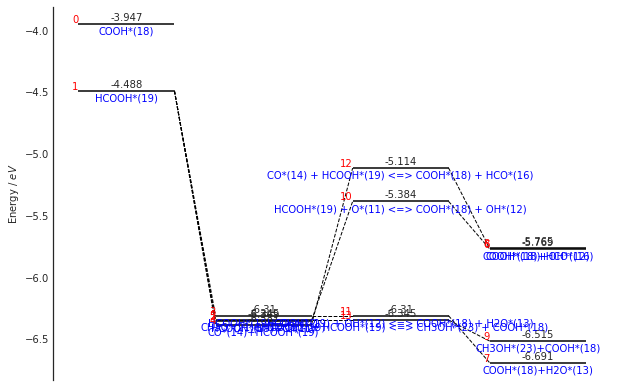

In [48]:
if "HCOOH*" in spc_trans.keys():
    ppt = pes_plot.pes_plot(cti_file)
    species = [
        spc_trans["COOH*"],
        spc_trans["HCOOH*"],
    ]
    ppt.add_species(species, 0)
    ppt.add_combined_species(reactant_list,1)
    ppt.add_reactions(rxn_list, 2)
    ppt.add_combined_species(product_list, 3)
    ppt.plot()
else:
    print("sorry, no formic acid")

species CO*(14)+HCOOH*(19) already in this diagram position
species CO*(14)+HCOOH*(19) already in this diagram position
species CO*(14)+HCOOH*(19) already in this diagram position
reaction CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) already in this diagram position
reaction CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) already in this diagram position
reaction CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) already in this diagram position
species COOH*(18)+HCO*(16) already in this diagram position
species COOH*(18)+HCO*(16) already in this diagram position
species COOH*(18)+HCO*(16) already in this diagram position


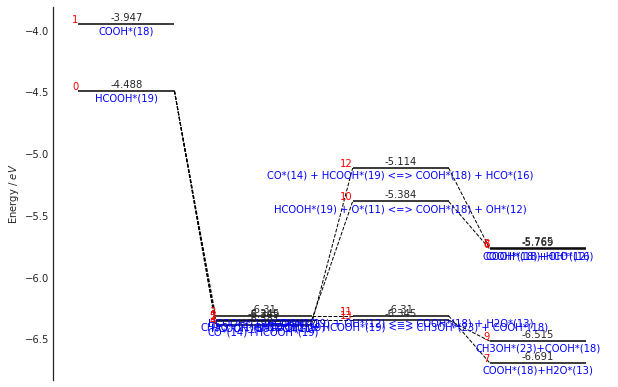

In [49]:
if "HCOOH*" in spc_trans.keys():
    ppt = pes_plot.pes_plot(cti_file)
    species = [
        spc_trans["HCOOH*"],
        spc_trans["COOH*"],
    ]
    ppt.add_species(species, 0)
    ppt.add_combined_species(reactant_list,1)
    ppt.add_reactions(rxn_list, 2)
    ppt.add_combined_species(product_list, 3)
    ppt.plot()
else:
    print("sorry, no formic acid")

### Make dot file for analyzing reaction network

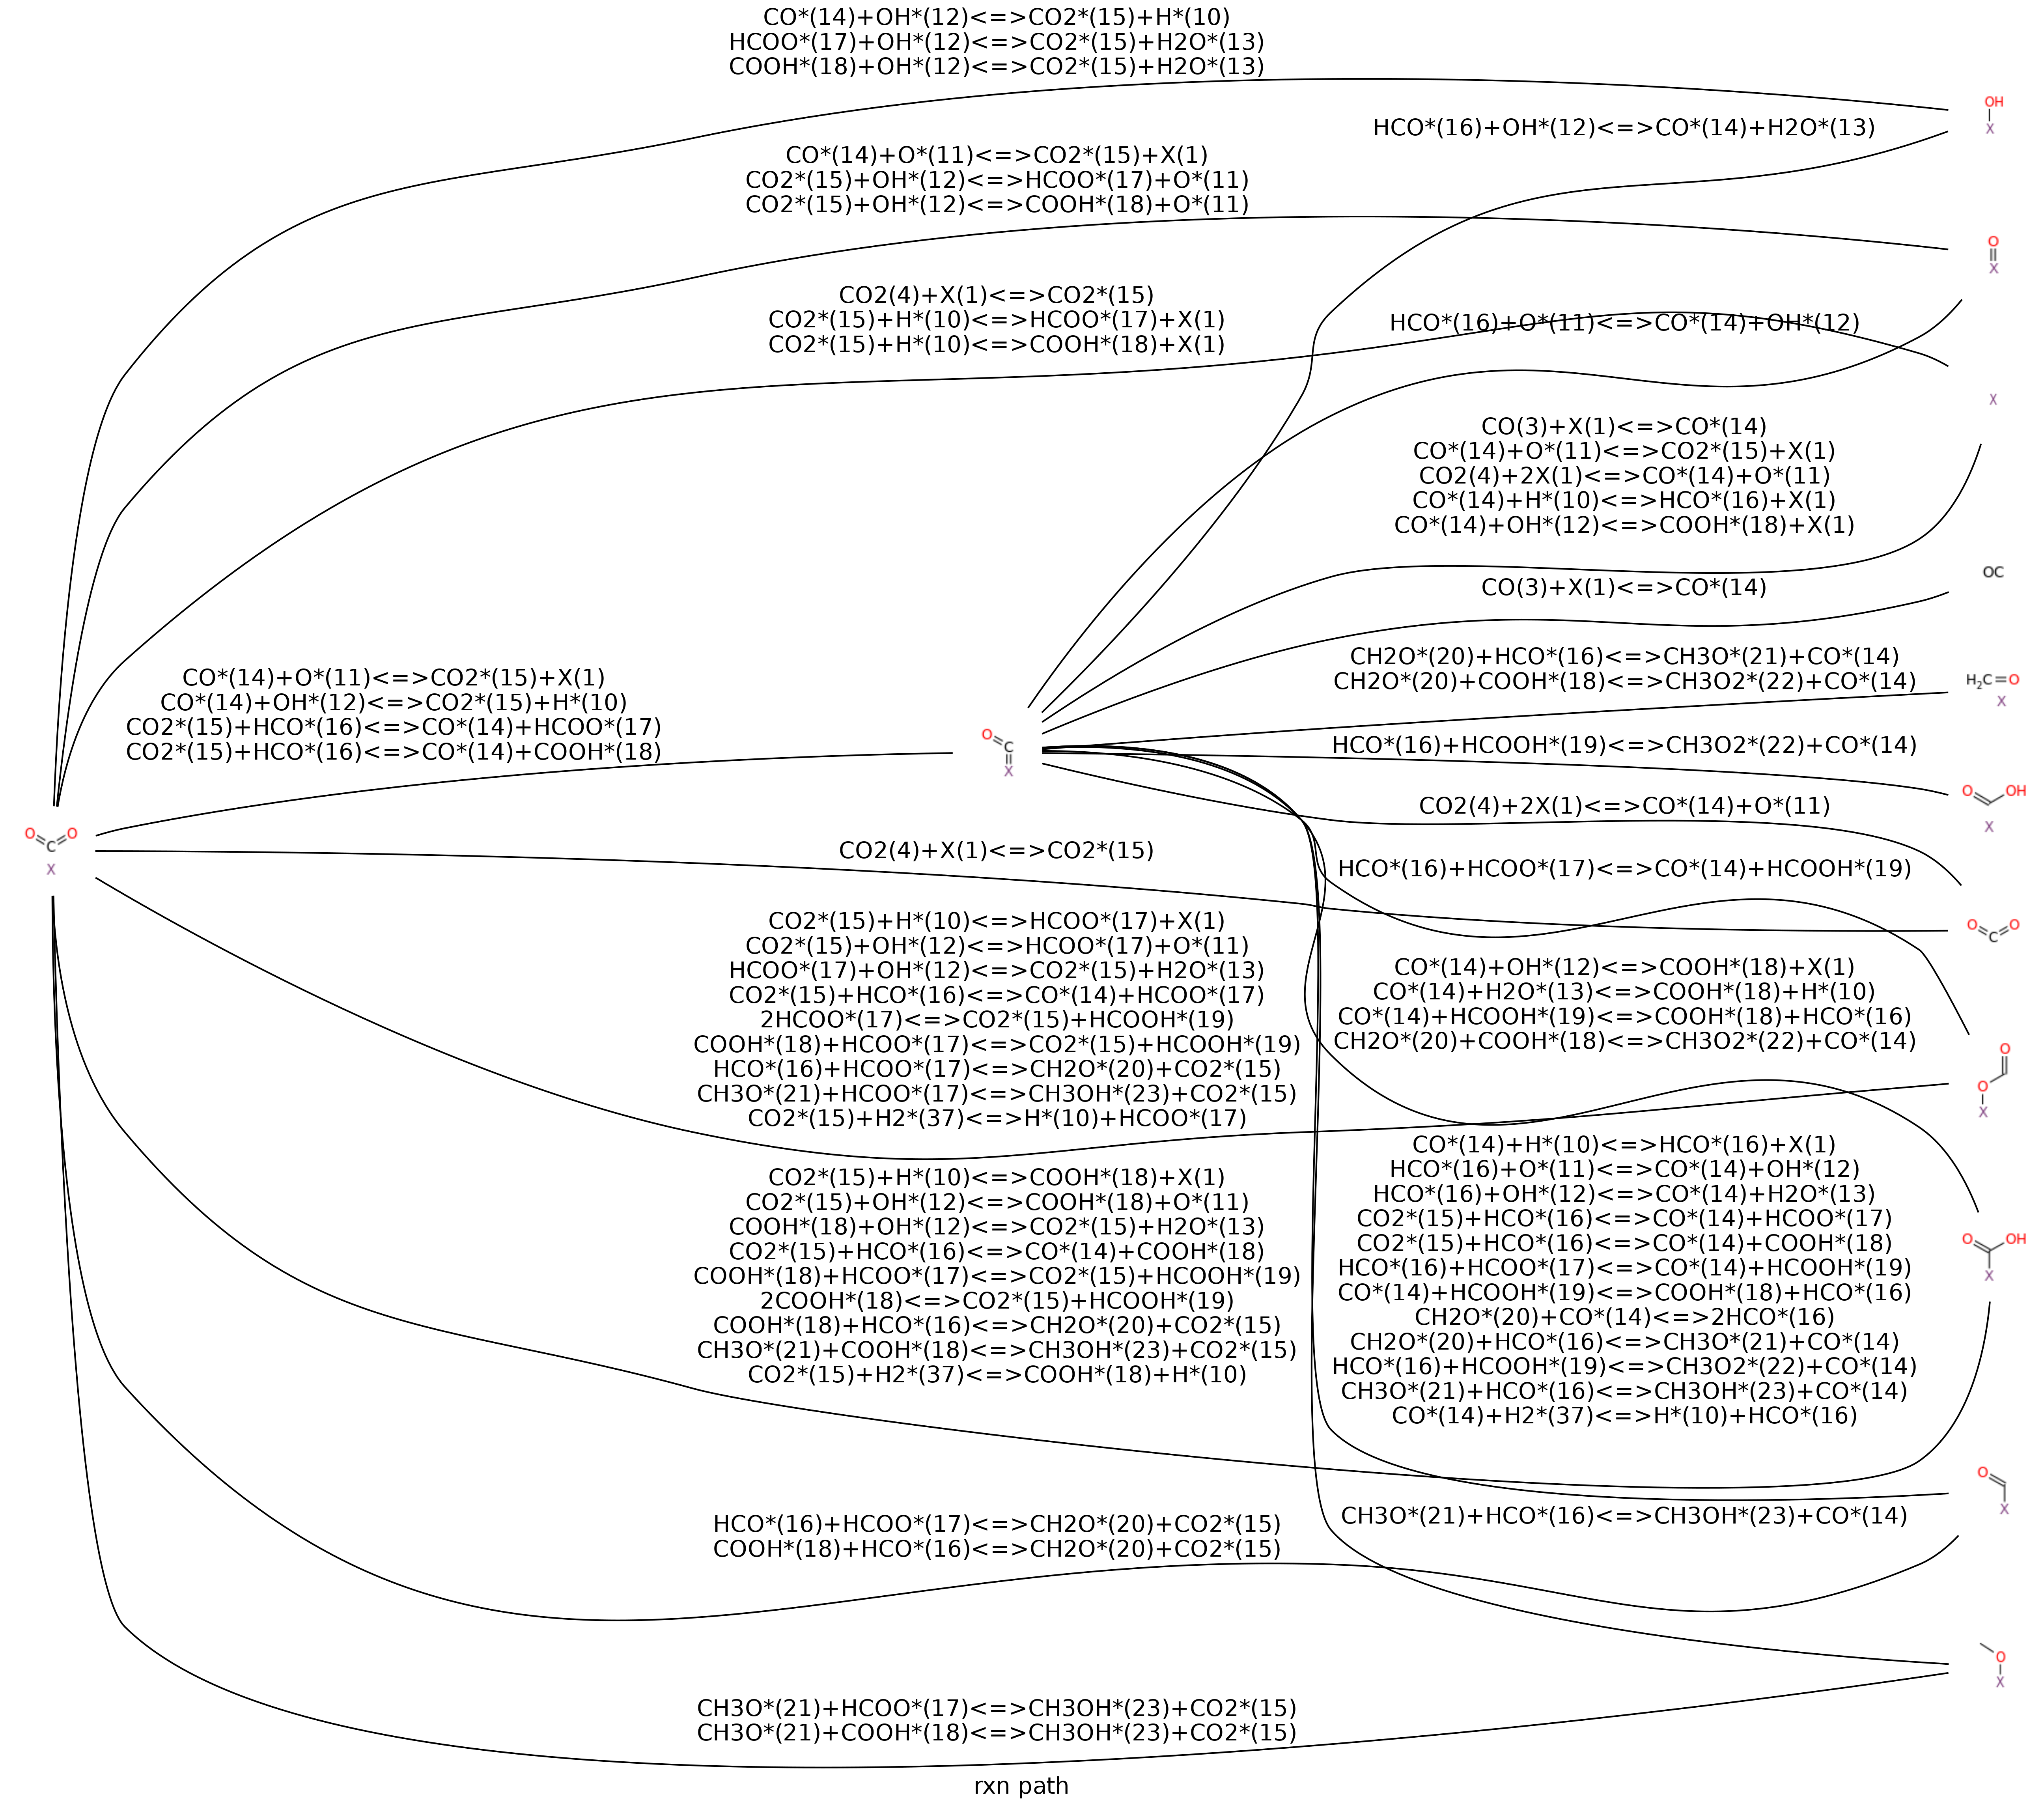

In [58]:
# name of output
file_name_dot = "reaction_network_diagrams/big_dot.dot"
file_name_png = file_name_dot.replace(".dot",".png")

# where to find molecule pictures
img_dir = f"./{commit}/species_pictures/"

# beginning and end of digraph
head_str = "graph reaction_paths {\ncenter=1;\n"
tail_str = ' label = "rxn path";\n rankdir=LR\n fontname = "Helvetica";\n}'

# if we want to flag reactions we can color them red
flag_rxn_str = [
    f'{spc_trans["CO*"]} + {spc_trans["OH*"]} <=> {spc_trans["COOH*"]} + {spc_trans["X"]}',
    f'{spc_trans["COOH*"]} + {spc_trans["OH*"]} <=> {spc_trans["CO2*"]} + {spc_trans["H2O*"]}'
]

spec_dot_dict = {}
rxn_dot_list =[]
connecting_rxns = {}

# combine all species for node making 
all_spec = gas.species_names + surface.species_names

# flag all reactions in which these species participate.  
selec_spec = [
    spc_trans["CO2*"],
    spc_trans["CO*"],
#     spc_trans["CH3O2*"],
    
]

# get all species and make them nodes
for node, spec in enumerate(all_spec):
    dot_str = f's{node} [ shape = "box" image="{img_dir+spec+".png"}" label="" width="0.75" height="0.75" imagescale=false fixedsize=false color="none" ];\n'
    spec_dot_dict.update({spec:[f's{node}', dot_str]})
    
# combine all reactions so we can iterate over all of them
all_reactions = gas.reactions() + surface.reactions()
       
# make connections for each reactant species.
for rxn in all_reactions:
    for reac in selec_spec:
        if reac in rxn.reactants:
            for prod in rxn.products.keys():
                reac_s = spec_dot_dict[reac][0]
                prod_s = spec_dot_dict[prod][0]
                mod_rxn_eq = rxn.equation.replace(" ", "") #.replace("<=>","\n<>\n")
                
#                 if rxn.equation in flag_rxn_str:
#                     dot_str = f'{reac_s} -- {prod_s} [fontname="Helvetica", color="red", width = 3.0, penwidth=1.0, arrowsize=1.0, label="connecting_rxns"];\n'
#                 else: 
                dot_str = f'{reac_s} -- {prod_s} [fontname="Helvetica", width = 3.0, penwidth=1.0, arrowsize=1.0, label="connecting_rxns"];\n'
                
                # get a list of all reactions that connect two nodes
                dot_key = f'{reac_s} -- {prod_s}'
                dot_key_reversed = f'{prod_s} -- {reac_s}'
                
                # make a new entry if there is not one 
                if dot_key not in connecting_rxns and dot_key_reversed not in connecting_rxns: 
                    connecting_rxns[dot_key] = [mod_rxn_eq]
                    
                # if the entry exists then append the reaction, 
                # if it is not already there
                elif dot_key in connecting_rxns:
                    if mod_rxn_eq not in connecting_rxns[dot_key]:
                        connecting_rxns[dot_key].append(mod_rxn_eq)
                
                # if the entry is there just reactants and products are reversed, 
                # check if the reaction is there 
                elif dot_key_reversed in connecting_rxns:
                    if mod_rxn_eq not in connecting_rxns[dot_key_reversed]:
                        connecting_rxns[dot_key_reversed].append(mod_rxn_eq)
                
        elif reac in rxn.products:
            for prod in rxn.reactants.keys():
                reac_s = spec_dot_dict[reac][0]
                prod_s = spec_dot_dict[prod][0]
                mod_rxn_eq = rxn.equation.replace(" ", "") #.replace("<=>","\n<>\n")
                
#                 if rxn.equation in flag_rxn_str:
#                     dot_str = f'{reac_s} -- {prod_s} [fontname="Helvetica", color="red", width = 3.0, penwidth=1.0, arrowsize=1.0, label="connecting_rxns"];\n'
#                 else: 
                dot_str = f'{reac_s} -- {prod_s} [fontname="Helvetica", width = 3.0, penwidth=1.0, arrowsize=1.0, label="connecting_rxns"];\n'
                
                # don't add duplicates
                if dot_str not in rxn_dot_list:
                    rxn_dot_list.append(dot_str)

                # get a list of all reactions that connect two nodes
                dot_key = f'{reac_s} -- {prod_s}'
                dot_key_reversed = f'{prod_s} -- {reac_s}'
                
                # make a new entry if there is not one 
                if dot_key not in connecting_rxns and dot_key_reversed not in connecting_rxns: 
                    connecting_rxns[dot_key] = [mod_rxn_eq]
                    
                # if the entry exists then append the reaction, 
                # if it is not already there
                elif dot_key in connecting_rxns:
                    if mod_rxn_eq not in connecting_rxns[dot_key]:
                        connecting_rxns[dot_key].append(mod_rxn_eq)
                
                # if the entry is there just reactants and products are reversed, 
                # check if the reaction is there 
                elif dot_key_reversed in connecting_rxns:
                    if mod_rxn_eq not in connecting_rxns[dot_key_reversed]:
                        connecting_rxns[dot_key_reversed].append(mod_rxn_eq)
                        


modified_rxn_dot_list = []                    
for connect, rxns in connecting_rxns.items():
    for dot_str in rxn_dot_list:
        if connect in dot_str:
            rxn_str = "\n".join(rxns)
            dot_str = dot_str.replace("connecting_rxns",rxn_str)
            modified_rxn_dot_list.append(dot_str)
            
rxn_dot_list = modified_rxn_dot_list
  
    
# remove species that do not participate in the set of reactions                    
for spec in list(spec_dot_dict.keys()):
    spec_search_str = f'{spec_dot_dict[spec][0]+" "}'
    if not any(spec_search_str in i for i in rxn_dot_list):
        del spec_dot_dict[spec]
                  
with open(file_name_dot, "w") as f:
    # add head
    f.write(head_str)
    
    # add reactions
    for connect in rxn_dot_list:
        f.write(connect)
    for value in spec_dot_dict.values():
        f.write(value[1])
    
    # add tail
    f.write(tail_str)

os.system(f"dot {file_name_dot} -Tpng -o {file_name_png} -Gdpi=300")

Image(file_name_png,width = 1000, unconfined=True)

### Out of all the reactions CO2 participates in, which has the highest ROP

In [51]:
rop_dict = {}
h2 = 0.75
for rxn in surface.reactions():
    if spc_trans["CO2*"] in rxn.reactants or spc_trans['CO2*'] in rxn.products:
        data_ref = rxn.equation + rop_str
        df_short = aggdata[(aggdata["T (K)"] == 528) & \
                   np.isclose(aggdata["X_h2 initial"],h2) & \
                   np.isclose(aggdata["CO2/(CO2+CO)"],co_co2)]
        rop_dict[rxn.equation] = df_short[data_ref].max()/surface.site_density

rop_dict = {k: v for k, v in sorted(rop_dict.items(), key=lambda item:abs(item[1]), reverse=True)}
rop_dict

{'CO2(4) + X(1) <=> CO2*(15)': 0.00029655554638233266,
 'CO2*(15) + HCO*(16) <=> CO*(14) + COOH*(18)': 0.0002817289284937973,
 'CO2*(15) + H*(10) <=> HCOO*(17) + X(1)': 1.464450174376459e-05,
 'CO2*(15) + H*(10) <=> COOH*(18) + X(1)': 1.7671073151181765e-07,
 'CO*(14) + OH*(12) <=> CO2*(15) + H*(10)': -3.37750018037625e-10,
 'COOH*(18) + OH*(12) <=> CO2*(15) + H2O*(13)': -3.4401175930967742e-12,
 'CO2*(15) + OH*(12) <=> HCOO*(17) + O*(11)': 1.0290072309436876e-12,
 'CO2*(15) + OH*(12) <=> COOH*(18) + O*(11)': 9.453895777911734e-13,
 'CH3O*(21) + COOH*(18) <=> CH3OH*(23) + CO2*(15)': -5.990906497793767e-14,
 'COOH*(18) + HCO*(16) <=> CH2O*(20) + CO2*(15)': -2.118324740895045e-14,
 'CH3O*(21) + HCOO*(17) <=> CH3OH*(23) + CO2*(15)': -1.5360057377844108e-15,
 'HCO*(16) + HCOO*(17) <=> CH2O*(20) + CO2*(15)': -5.442843564639918e-16,
 '2 COOH*(18) <=> CO2*(15) + HCOOH*(19)': -2.796699242923353e-16,
 'HCOO*(17) + OH*(12) <=> CO2*(15) + H2O*(13)': -1.1156506768539208e-17,
 'COOH*(18) + HCOO*(17

### out of the reactions from CO to HCO, which is the highest ROP? 

In [60]:
rop_dict = {}
reac1 = spc_trans["CO2*"]
prod1 = spc_trans['CO*']
for rxn in surface.reactions():
    if (reac1 in rxn.reactants and prod1 in rxn.products) \
    or (prod1 in rxn.reactants and reac1 in rxn.products):
        data_ref = rxn.equation + rop_str
        df_short = aggdata[(aggdata["T (K)"] == 528) & \
                   np.isclose(aggdata["X_h2 initial"],h2) & \
                   np.isclose(aggdata["CO2/(CO2+CO)"],co_co2)]
        rop_dict[rxn.equation] = df_short[data_ref].max()/surface.site_density

rop_dict = {k: v for k, v in sorted(rop_dict.items(), key=lambda item:abs(item[1]), reverse=True)}
rop_dict

{'CO2*(15) + HCO*(16) <=> CO*(14) + COOH*(18)': 0.0002817289284937973,
 'CO*(14) + OH*(12) <=> CO2*(15) + H*(10)': -3.37750018037625e-10,
 'CO*(14) + O*(11) <=> CO2*(15) + X(1)': 0.0,
 'CO2*(15) + HCO*(16) <=> CO*(14) + HCOO*(17)': 0.0}

### what about CO2* to CO*

In [62]:
rop_dict = {}
for rxn in surface.reactions():
    if (spc_trans["CO2*"] in rxn.reactants and spc_trans['CO*'] in rxn.products) \
    or (spc_trans['CO*'] in rxn.reactants and spc_trans["CO2*"] in rxn.products):
        data_ref = rxn.equation + rop_str
        df_short = aggdata[(aggdata["T (K)"] == 528) & \
                   np.isclose(aggdata["X_h2 initial"],h2) & \
                   np.isclose(aggdata["CO2/(CO2+CO)"],co_co2)]
        rop_dict[rxn.equation] = df_short[data_ref].max()/surface.site_density

rop_dict = {k: v for k, v in sorted(rop_dict.items(), key=lambda item:abs(item[1]), reverse=True)}
rop_dict

{'CO2*(15) + HCO*(16) <=> CO*(14) + COOH*(18)': 0.0002817289284937973,
 'CO*(14) + OH*(12) <=> CO2*(15) + H*(10)': -3.37750018037625e-10,
 'CO*(14) + O*(11) <=> CO2*(15) + X(1)': 0.0,
 'CO2*(15) + HCO*(16) <=> CO*(14) + HCOO*(17)': 0.0}

In [63]:
thermo_file = rmg_model_path + "base/chemkin/chem_annotated-surface.inp"
model_dict_file = rmg_model_path + "base/chemkin/species_dictionary.txt"

chmkn = chemkin.load_chemkin_file(
    thermo_file, 
    dictionary_path=model_dict_file, 
    transport_path=None, 
    read_comments=True, 
    thermo_path=None,
    use_chemkin_names=True, 
    check_duplicates=True, 
    generate_resonance_structures=True
)

parse chemkin file and get reactions that have the labelled species in their 

In [66]:
interest_species = {}
spec1 = model_dict[spc_trans["CO*"]]
spec2 = model_dict[spc_trans["CO2*"]]
#     for reac in chmkn[1][10].reactants:
for rxn in chmkn[1]:
    if (any(reac.is_isomorphic(spec1) for reac in rxn.reactants) and \
        any(reac.is_isomorphic(spec2) for reac in rxn.products)) or \
    (any(reac.is_isomorphic(spec2) for reac in rxn.reactants) and \
     any(reac.is_isomorphic(spec1) for reac in rxn.products)):
        # remove (#) so it is neater
         if "Estimated" in rxn.kinetics.comment:
            print(
                rxn.to_labeled_str(),
                "\n" + rxn.kinetics.comment,
                "\n" + rxn.to_chemkin(),
                "\n" + str(rxn.duplicate),
                "\n")
                

CO2* + HCO* <=> CO* + HCOO* 
Estimated using template [O=C;*C-H] for rate rule [O=C=O;*C-H]
Euclidian distance = 1.0
Multiplied by reaction path degeneracy 2.0
family: Surface_Adsorption_Abstraction_vdW 
! Template reaction: Surface_Adsorption_Abstraction_vdW
! Flux pairs: CO2*(15), HCOO*(17); HCO*(16), CO*(14); 
! Estimated using template [O=C;*C-H] for rate rule [O=C=O;*C-H]
! Euclidian distance = 1.0
! Multiplied by reaction path degeneracy 2.0
! family: Surface_Adsorption_Abstraction_vdW
CO2*(15)+HCO*(16)=CO*(14)+HCOO*(17)                 3.628000e+20 0.000     9.685    
 
False 

CO2* + HCO* <=> CO* + COOH* 
Estimated using template [AdsorbateVdW;*C-H] for rate rule [CO2;*C-H]
Euclidian distance = 4.0
Multiplied by reaction path degeneracy 2.0
family: Surface_Adsorption_Abstraction_vdW 
! Template reaction: Surface_Adsorption_Abstraction_vdW
! Flux pairs: CO2*(15), COOH*(18); HCO*(16), CO*(14); 
! Estimated using template [AdsorbateVdW;*C-H] for rate rule [CO2;*C-H]
! Euclidian di

In [55]:
rxn.to_chemkin()

'! Template reaction: Surface_Abstraction_Single_vdW\n! Flux pairs: CH3O*(21), CH3OH*(23); H2*(37), H*(10); \n! Estimated using template [Donating;Abstracting] for rate rule [H-H;*O]\n! Euclidian distance = 1.4142135623730951\n! Multiplied by reaction path degeneracy 2.0\n! family: Surface_Abstraction_Single_vdW\n! Ea raised from -35.2 to 0.0 kJ/mol.\nH2*(37)+CH3O*(21)=H*(10)+CH3OH*(23)                 2.000000e+17 0.000     0.000    \n'

In [56]:
dir(rxn)

['SurfaceArrhenius',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_degeneracy',
 '_repr_png_',
 'allow_max_rate_violation',
 'allow_pdep_route',
 'calculate_coll_limit',
 'calculate_microcanonical_rate_coefficient',
 'calculate_tst_rate_coefficient',
 'calculate_tst_rate_coefficients',
 'can_tst',
 'check_collision_limit_violation',
 'comment',
 'copy',
 'degeneracy',
 'draw',
 'duplicate',
 'elementary_high_p',
 'ensure_species',
 'estimator',
 'family',
 'fix_barrier_height',
 'fix_diffusion_limited_a_factor',
 'generate_3d_ts',
 'generate_high_p_limit_kinetics',
 'generate_pairs',
 'generate_reverse_rate_coefficient',
 'get_enthalpies_of_react